In [1]:
import os
os.environ['R_HOME'] = "/Library/Frameworks/R.framework/Resources"

In [2]:
import pandas as pd
import numpy as np
from _py_density_estimation import get_bw, rde_training_py
from _pricing_mechanisms import RSRDE

In [3]:
# df = pd.read_xml("~/Downloads/97_341_all_files/97_341_database_cumulative.xml")
# df.to_csv("~/Desktop/auction97.csv")

In [4]:
df = pd.read_csv("~/Desktop/auction97.csv")
df.head()

/var/folders/yh/wjjhzwhx54b5t1_q6yd628240000gn/T/ipykernel_39101/232481653.py:1: DtypeWarning: Columns (36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("~/Desktop/auction97.csv")


,Unnamed: 0,auction_id,auction_description,round,item_name,item_description,bidder_name,bidder_frn,market,block,...,solver_optimum_percentage,solver_options,price_weight,previous_pw_bidder,previous_pw_bidder_frn,round_of_previous_pwb,round_of_withdrawal,round_withdrawn_pwb_placed,withdrawn_pwb_amount,withdrawn_net_pwb_amount
0,0,97,AWS-3,1.0,AW-BEA001-H,Bangor ME,T-Mobile License LLC,1565449.0,BEA001,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,97,AWS-3,1.0,AW-BEA002-H,Portland ME,T-Mobile License LLC,1565449.0,BEA002,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,97,AWS-3,1.0,AW-BEA002-J,Portland ME,AT&T Wireless Services 3 LLC,23910920.0,BEA002,J,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,97,AWS-3,1.0,AW-BEA003-B1,Boston-Worcester MA-NH-RI-VT,2014 AWS Spectrum Bidco Corporation,23933575.0,BEA003,B1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,97,AWS-3,1.0,AW-BEA003-H,Boston-Worcester MA-NH-RI-VT,"Northstar Wireless, LLC",23917453.0,BEA003,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
useful_df = df[["round", "item_name", "block", "bidder_name", "bid_amount"]].dropna()
useful_df.head()

,round,item_name,block,bidder_name,bid_amount
0,1.0,AW-BEA001-H,H,T-Mobile License LLC,43000.0
1,1.0,AW-BEA002-H,H,T-Mobile License LLC,387000.0
2,1.0,AW-BEA002-J,J,AT&T Wireless Services 3 LLC,775000.0
3,1.0,AW-BEA003-B1,B1,2014 AWS Spectrum Bidco Corporation,4539000.0
4,1.0,AW-BEA003-H,H,"Northstar Wireless, LLC",13616000.0


In [6]:
clean_df = useful_df.sort_values("round", ascending = False).groupby(["item_name", "bidder_name"]).first().reset_index()
clean_df.head()

,item_name,bidder_name,round,block,bid_amount
0,AW-BEA001-A1,American AWS-3 Wireless I L.L.C.,19.0,A1,9800.0
1,AW-BEA001-A1,"Northstar Wireless, LLC",255.0,A1,36000.0
2,AW-BEA001-A1,"SNR Wireless LicenseCo, LLC",255.0,A1,36000.0
3,AW-BEA001-A1,"Sofio, Joseph A",254.0,A1,31000.0
4,AW-BEA001-B1,2014 AWS Spectrum Bidco Corporation,39.0,B1,71000.0


array([[<Axes: title={'center': 'A1'}>, <Axes: title={'center': 'B1'}>],
       [<Axes: title={'center': 'G'}>, <Axes: title={'center': 'H'}>],
       [<Axes: title={'center': 'I'}>, <Axes: title={'center': 'J'}>]],
      dtype=object)

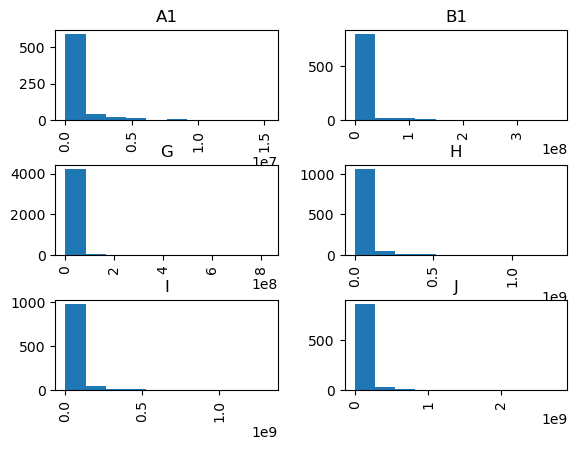

In [7]:
clean_df.hist("bid_amount", by = "block")

array([[<Axes: title={'center': 'A1'}>, <Axes: title={'center': 'B1'}>],
       [<Axes: title={'center': 'G'}>, <Axes: title={'center': 'H'}>],
       [<Axes: title={'center': 'I'}>, <Axes: title={'center': 'J'}>]],
      dtype=object)

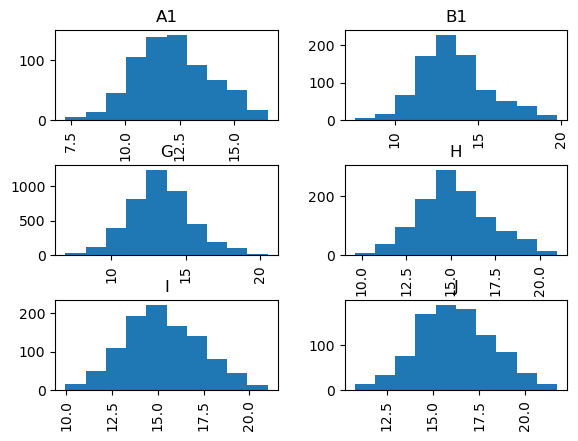

In [8]:
clean_df["log_bid"] = np.log(clean_df["bid_amount"])
clean_df.hist("log_bid", by = "block")

In [9]:
min(clean_df["log_bid"]), max(clean_df["log_bid"])

(6.907755278982137, 21.73956985348685)

# Training Data

In [10]:
clean_df.groupby("block")["bid_amount"].count()

block
A1     679
B1     846
G     4286
H     1126
I     1037
J      923
Name: bid_amount, dtype: int64

In [11]:
train_data = clean_df.groupby("block")["bid_amount"].apply(list).tolist()
[len(train_data[i]) for i in range(len(train_data))]

[679, 846, 4286, 1126, 1037, 923]

# Test Data

In [12]:
clean_df.groupby("item_name")["bid_amount"].count()

item_name
AW-BEA001-A1    4
AW-BEA001-B1    5
AW-BEA001-H     7
AW-BEA001-I     7
AW-BEA001-J     6
               ..
AW-CMA730-G     4
AW-CMA731-G     4
AW-CMA732-G     3
AW-CMA733-G     5
AW-CMA734-G     5
Name: bid_amount, Length: 1614, dtype: int64

In [13]:
test_data = clean_df.groupby("item_name")["bid_amount"].apply(list).tolist()
[len(test_data[i]) for i in range(len(test_data))]

[4,
 5,
 7,
 7,
 6,
 4,
 5,
 7,
 4,
 5,
 5,
 5,
 7,
 6,
 6,
 4,
 6,
 7,
 4,
 6,
 4,
 5,
 9,
 6,
 4,
 4,
 6,
 6,
 6,
 5,
 4,
 6,
 7,
 7,
 5,
 4,
 6,
 10,
 8,
 7,
 4,
 4,
 2,
 5,
 4,
 4,
 6,
 8,
 9,
 9,
 4,
 5,
 8,
 6,
 3,
 5,
 5,
 6,
 6,
 5,
 4,
 6,
 6,
 6,
 6,
 5,
 5,
 8,
 6,
 6,
 4,
 5,
 8,
 5,
 3,
 4,
 5,
 7,
 8,
 4,
 5,
 5,
 8,
 7,
 6,
 4,
 5,
 7,
 5,
 5,
 4,
 5,
 9,
 4,
 5,
 3,
 4,
 7,
 4,
 5,
 5,
 6,
 8,
 7,
 7,
 5,
 6,
 9,
 6,
 8,
 6,
 4,
 8,
 7,
 6,
 4,
 5,
 7,
 4,
 6,
 4,
 5,
 8,
 5,
 6,
 4,
 5,
 6,
 6,
 6,
 4,
 5,
 8,
 8,
 5,
 3,
 5,
 4,
 3,
 4,
 6,
 4,
 8,
 4,
 8,
 5,
 5,
 5,
 8,
 7,
 5,
 5,
 6,
 11,
 8,
 4,
 4,
 6,
 5,
 7,
 5,
 4,
 6,
 4,
 5,
 4,
 5,
 5,
 7,
 7,
 4,
 4,
 5,
 4,
 6,
 4,
 5,
 4,
 3,
 3,
 4,
 5,
 7,
 7,
 6,
 4,
 5,
 5,
 7,
 6,
 2,
 4,
 5,
 5,
 4,
 5,
 5,
 9,
 7,
 9,
 4,
 5,
 5,
 6,
 6,
 3,
 5,
 5,
 4,
 5,
 3,
 5,
 4,
 4,
 5,
 2,
 4,
 7,
 5,
 5,
 4,
 4,
 3,
 4,
 4,
 4,
 5,
 6,
 7,
 5,
 4,
 5,
 5,
 6,
 7,
 4,
 5,
 8,
 6,
 4,
 2,
 5,
 6,
 6,
 8,
 3,
 5,
 7,
 4,
 4

# Run Auctions

In [14]:
training_results = rde_training_py(train_hist = train_data,
                                   train_bws = [get_bw(bids) for bids in train_data],
                                   lower = 6.9, upper = 21.8)

In [17]:
prices = []
for i in range(len(test_data)):
    prices_at_i = []
    for seed in range(200):
        bids_list = test_data[i]
        bids = dict(zip(range(len(bids_list)), bids_list))
        price, cdf = RSRDE(bids, lower = 6.9, upper = 21.8, random_seed = seed, training_results = training_results)
        prices_at_i.append(price)
    prices.append(prices_at_i)

In [18]:
import dill 
with open("data/real.pkl", "wb") as file:
    dill.dump(prices, file)